<a href="https://colab.research.google.com/github/Takara47/CSci-167-participation/blob/main/Notebook8/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-evhi0lti
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-evhi0lti
  Resolved https://github.com/greydanus/mnist1d to commit 68cb6b2d1d3a956cc2e9035e5a9860b66e33d642
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post15-py3-none-any.whl size=14561 sha256=17c55df8517c3e96b8cc2737199bd830afe9a9624ce4d710c57f7017fbda8cc9
  Stored in directory: /tmp/pip-ephem-wheel-cache-cajf0q79/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [86]:
D_i = 40    # Input dimensions
D_k = 400   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
    torch.nn.Linear(D_i, D_k),
    torch.nn.ReLU(),
    torch.nn.Linear(D_k, D_k),
    torch.nn.ReLU(),
    torch.nn.Linear(D_k, D_k),
    torch.nn.ReLU(),
    torch.nn.Linear(D_k, D_o),);


def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  if isinstance(layer_in, torch.nn.Linear):
    torch.nn.init.kaiming_normal_(layer_in.weight)
    torch.nn.init.zeros_(layer_in.bias)


# Call the function you just defined
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=10, bias=True)
)

In [87]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=50, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.438118, train error 55.75,  test loss 1.567298, test error 63.40
Epoch     1, train loss 1.057749, train error 37.70,  test loss 1.336213, test error 51.80
Epoch     2, train loss 0.752433, train error 25.20,  test loss 1.148156, test error 42.80
Epoch     3, train loss 0.622995, train error 21.45,  test loss 1.098316, test error 40.40
Epoch     4, train loss 0.524606, train error 19.38,  test loss 1.155286, test error 38.10
Epoch     5, train loss 0.185078, train error 5.00,  test loss 0.914434, test error 32.90
Epoch     6, train loss 0.163240, train error 5.22,  test loss 1.083660, test error 32.40
Epoch     7, train loss 0.102876, train error 2.90,  test loss 1.079054, test error 30.80
Epoch     8, train loss 0.091739, train error 2.80,  test loss 1.115386, test error 33.10
Epoch     9, train loss 0.046446, train error 0.97,  test loss 1.117546, test error 30.80
Epoch    10, train loss 0.017867, train error 0.20,  test loss 1.066563, test error 30.00
Epoch

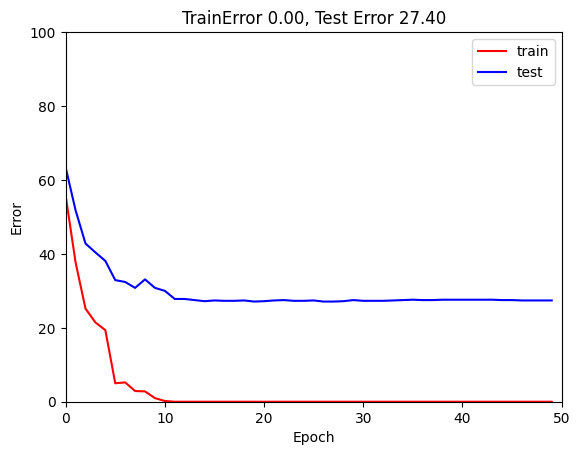

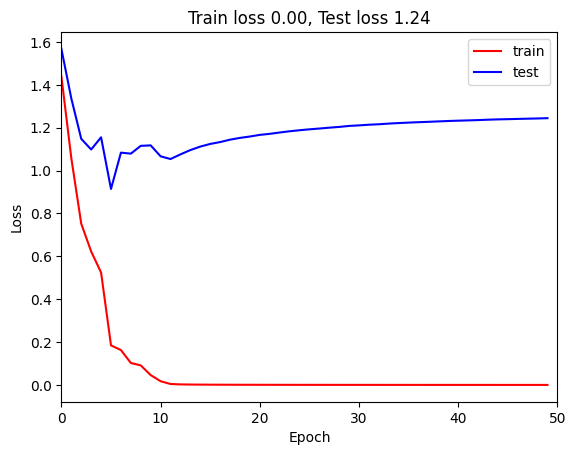

In [88]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Reducing the hidden layers helped it not overfit and thus the Test loss didn't shoot up after a time, but the overall error was greater.  Increasing the number of layers caused it to overfit faster.

Reducing the number of hidden units in each layer caused it once again to not overfit but had a worse overall error.  Increasing the hidden units also seemed to smooth out the loss and lower the error but this was very slight and it quickly saw diminishing returns.

Increasing learning rate didn't seem to have a noticable effect other than it overfit in a slightely later epoch.  Decreasing the learning rate helped with overfitting but once again increased the error.

The best results I managed to get was to add another layer, increase the hidden units to 400, drop the step size to 5, drop batch size to 50 and increase the gamma to 0.8.  This gave the least test error I observed and also the loss was fairely flat but did bump back up a bit.



Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

It can be good measuring stick for preformance and getting good hyperparmeters, but it is important to not optimize it to much to the test data.  This is why it is good to have a completely seperate set of data that can be used as a true test performanced.